# Machine Learning exploration on simple, synthetic dust infra-red spectra

B.L. de Vries Jun 2022

We will make a set of synthetic (calculated) spectra using the simplest model (optically thin, blackbody radiation). We will use three dust species with fixed particle size (0.1 micron) and one temperature for all dust grains.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, random
from sklearn.decomposition import PCA
import sklearn.linear_model

## Reading in the observed spectra

Reading in the currently available real observations

In [4]:
directory = "data/raw/TTau/IRS-Christian/"
files = os.listdir(directory)
exclude = [files[15]]
obs_spectra, source_names = [], []
for f in files:
    if f in exclude:
        print("Excluding: ", f)
    else:
        obj_name = f.split('.csv')[0] # Get the object name from the file name
        source_names.append(obj_name)
        s = pd.read_csv(os.path.join(directory, f)).rename(columns = {'wavelength':'w', 'flux':'f'}) 
        obs_spectra.append(s)
print("Number of observed objects: ", len(obs_spectra))

Excluding:  TW-Hya.csv
Number of observed objects:  25


### Defining a new resolution

In [5]:
bins = np.linspace(5.,35., num=150)#121)#[0, 5,10,15,20,25,30,35,40]
new_wavelength = []
for i in range(len(bins)):
    if i < len(bins)-1: 
        new_wavelength.append(bins[i]+(bins[i+1]-bins[i])/2)
new_wavelength = np.array(new_wavelength)

res = new_wavelength[1:-1] - new_wavelength[0:-2]
print("New resolution: ",round(res.mean(),4),"+/-", round(res.std(),4))

New resolution:  0.2013 +/- 0.0


In [6]:
def rebin(s, bins, wavelength_col = "w", value_col = "a", handle_nan = True):
    s['w_bins'] = pd.cut(s[wavelength_col], bins) # Cut the wavelength into bins
    s_bin = s.groupby(['w_bins'])[value_col].mean().reset_index() # Group by bin and average in the bin
    s = np.array(s_bin[value_col])
    if handle_nan:
        found = np.isnan(s)
        if found.any():
            s = [0 if found[i] else s[i] for i in range(len(s))]
    return s

### Rebinning all observed spectra

In [7]:
obs_spectra_bin = np.array([rebin(obs_spectra[i], bins, value_col='f', handle_nan = True) 
                            for i in range(len(obs_spectra))])
obs_spectra_bin.shape

(25, 149)

### Having a look at the spectra and binning

/Users/benv/anaconda3/envs/astroml/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  after removing the cwd from sys.path.
/Users/benv/anaconda3/envs/astroml/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/Users/benv/anaconda3/envs/astroml/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()
/Users/benv/anaconda3/envs/astroml/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing no

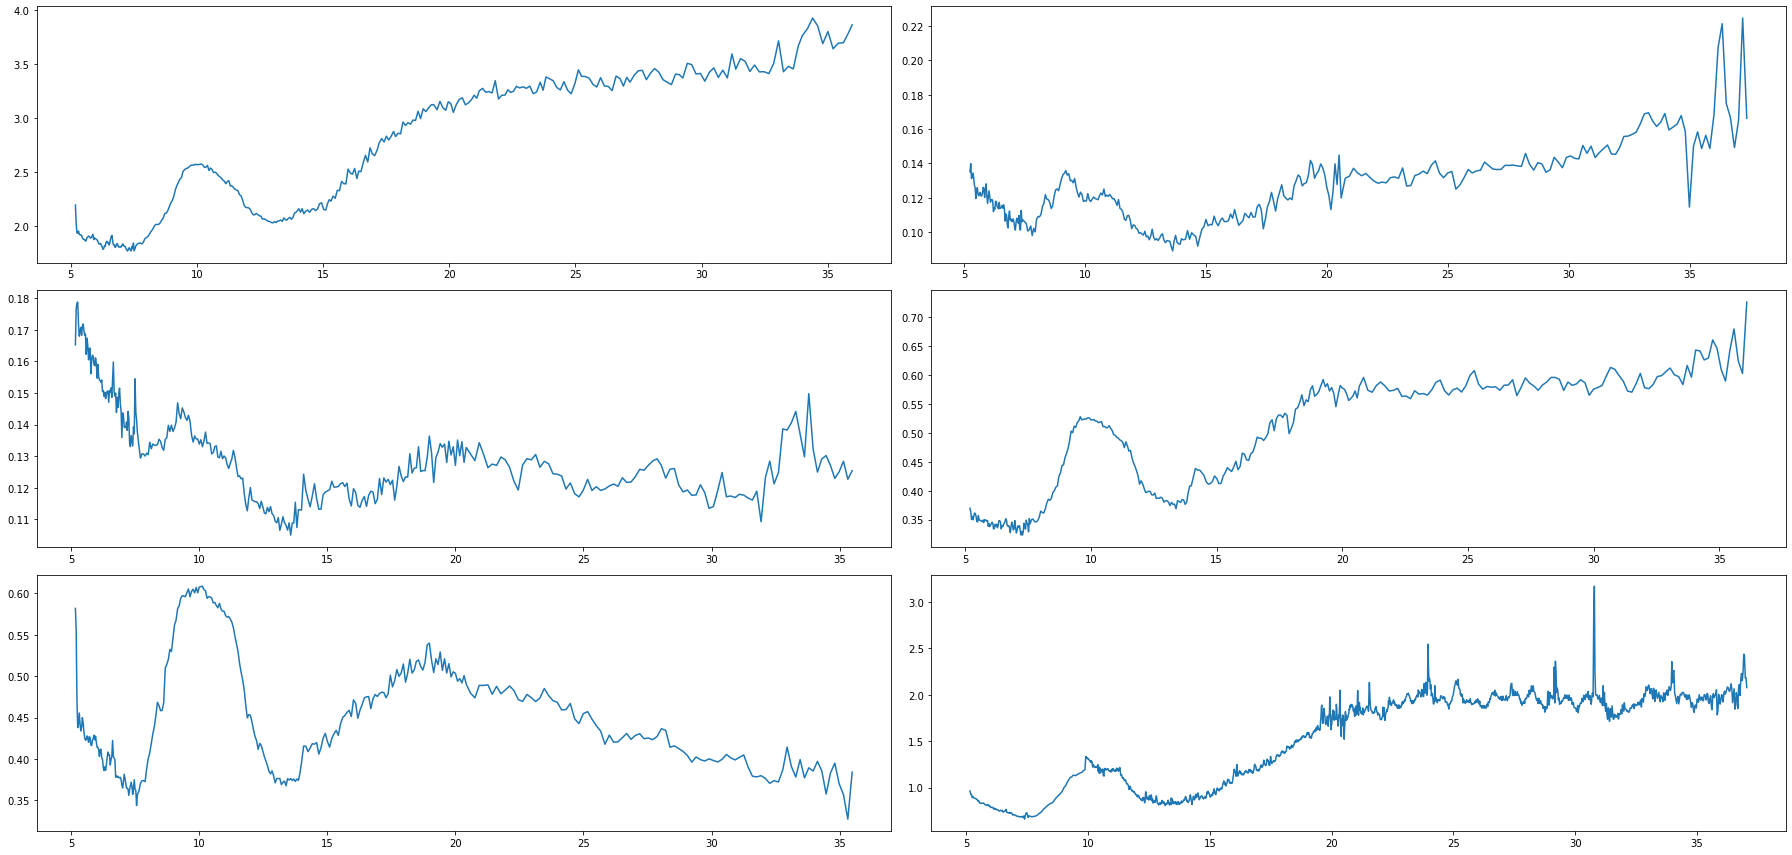

In [8]:
fig = plt.figure(figsize=(25,12))
subplt_nr = '32'
i = 5
plt.subplot(subplt_nr+'1')
plt.plot(obs_spectra[i]['w'], obs_spectra[i]['f'], label='original')
#plt.plot(new_wavelength, obs_spectra_bin[i], ".", label='binned')
#plt.title("Example plot: "+source_names[i])

i = 8
plt.subplot(subplt_nr+'2')
plt.plot(obs_spectra[i]['w'], obs_spectra[i]['f'], label='original')
#plt.plot(new_wavelength, obs_spectra_bin[i], ".", label='binned')
#plt.title("Example plot: "+source_names[i])

i = 10
plt.subplot(subplt_nr+'3')
plt.plot(obs_spectra[i]['w'], obs_spectra[i]['f'], label='original')
#plt.plot(new_wavelength, obs_spectra_bin[i], ".", label='binned')
#plt.title("Example plot: "+source_names[i])


i = 12
plt.subplot(subplt_nr+'4')
plt.plot(obs_spectra[i]['w'], obs_spectra[i]['f'], label='original')
#plt.plot(new_wavelength, obs_spectra_bin[i], ".", label='binned')
#plt.title("Example plot: "+source_names[i])

i = 16
plt.subplot(subplt_nr+'5')
plt.plot(obs_spectra[i]['w'], obs_spectra[i]['f'], label='original')
#plt.plot(new_wavelength, obs_spectra_bin[i], ".", label='binned')
#plt.title("Example plot: "+source_names[i])
#plt.xlabel("Wavelength(micron)")
#plt.ylabel("Flux (Jy)")

i = 24
plt.subplot(subplt_nr+'6')
plt.plot(obs_spectra[i]['w'], obs_spectra[i]['f'], label='original')
#plt.plot(new_wavelength, obs_spectra_bin[i], ".", label='binned')
#plt.title("Example plot: "+source_names[i])

#plt.legend()
fig.tight_layout()
plt.show()
plt.close()

## Reading in and calculating synthetic spectra

### Reading in the opacity files

We need the opacity files to calculate infrared spectra. Opacities are more or less the cross section of the dust particles (in this case per gram of material). We consider three different types of dust: crystalline forsterite and enstatite as well as amorphous silicate.

In [9]:
directory = "opacities"
file_forsterite = 'Forsterite0.1.Kabs'
opac_fo = np.loadtxt(os.path.join(directory, file_forsterite))
file_amorphSilicate = 'AmorphousOlivineX0.5_0.1.Kabs'
opac_am = np.loadtxt(os.path.join(directory, file_amorphSilicate))
file_enstatite = 'Enstatite0.1.Kabs'
opac_en = np.loadtxt(os.path.join(directory, file_enstatite))

Checking the resolution of the wavelength grid

In [10]:
print("Do all files have the same resolution: ", all((opac_en[:,0] == opac_am[:,0]) & (opac_fo[:,0] == opac_am[:,0])) )

Do all files have the same resolution:  True


In [11]:
res = opac_fo[1:-1,0] - opac_fo[0:-2,0]
print("Resolution: ",round(res.mean(),4),"+/-", round(res.std(),4))

Resolution:  0.0699 +/- 0.0405


We see the resolution of the opacities varies with wavelength. In this case we will manually make sure that the new resolution is not smaller than the original so that we get NaN values.

### Im using pandas for the rebinning

In [12]:
opac_fo_df = pd.DataFrame(opac_fo, columns=['w', 'a'])
opac_am_df = pd.DataFrame(opac_am, columns=['w', 'a'])
opac_en_df = pd.DataFrame(opac_en, columns=['w', 'a'])

In [13]:
opac_fo_bin = rebin(opac_fo_df, bins)
opac_en_bin = rebin(opac_en_df, bins)
opac_am_bin = rebin(opac_am_df, bins)

print("Length of the new wavelength grid: ", opac_fo_bin.shape)

Length of the new wavelength grid:  (149,)


### Lets see what the opacities look like

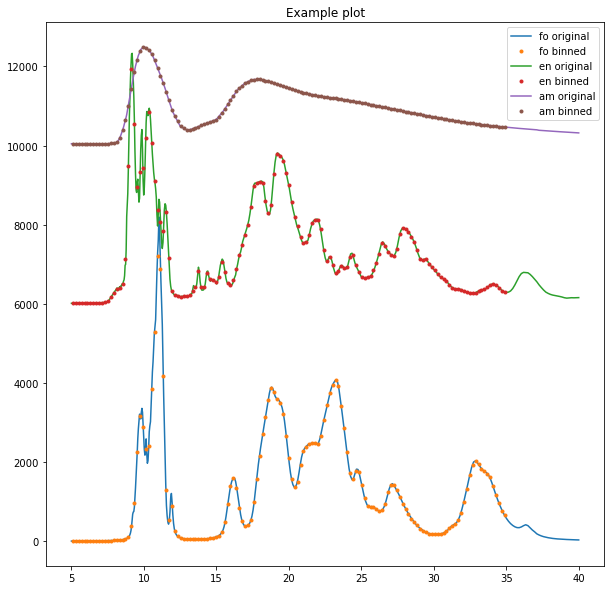

In [14]:
plotfile=''
plt.figure(figsize=(10,10))
plt.plot(opac_fo[:,0], opac_fo[:,1], "-", label='fo original')
plt.plot(new_wavelength, opac_fo_bin, ".", label='fo binned')
plt.plot(opac_en[:,0], opac_en[:,1]+6000, label='en original')
plt.plot(new_wavelength, opac_en_bin+6000, ".", label='en binned')
plt.plot(opac_am[:,0], opac_am[:,1]+10000, label='am original')
plt.plot(new_wavelength, opac_am_bin+10000, ".", label='am binned')
plt.title("Example plot")
plt.legend()
plt.show()
plt.close()

In [15]:
# plotfile=''
# plt.figure(figsize=(15,10))
# plt.plot(opac_fo[:,0], opac_fo[:,1]/35000, "-", label='fo original')
# i = 7
# plt.plot(obs_spectra[i]['w'], obs_spectra[i]['f'], label='original')
# #plt.plot(new_wavelength, obs_spectra_bin[i], ".", label='binned')
# #plt.title("Example plot: "+source_names[i])

# #plt.plot(new_wavelength, opac_fo_bin, ".", label='fo binned')
# plt.show()
# plt.close()

### Now we code Planks Law for blackbody radiation and generate a simple optically thin, one temperature, model

In our optically thin case the radiation is proportional to a blackbody radiator times the opacities weighted with their abundances

In [16]:
def B(lambd, T, micron=True):
    c = 299792458 # metres per second.
    h = 6.62607015e-34 # joule second
    k = 1.380649e-23 # joule per kelvin (K)
    
    if micron:
        lambd = lambd*1e-6
    return (2*h*c**2/lambd**5) * 1 / (np.exp(h*c/(k*T*lambd))-1)

def syn_spec(w, a, opac, T):
    spec = np.zeros(opac[0].shape)
    for i in range(len(a)):
        spec = spec + a[i]*opac[i]
    return B(w, T) * spec

### Lets see what the planck functions look like

Just a check to see if the planck functions look correct

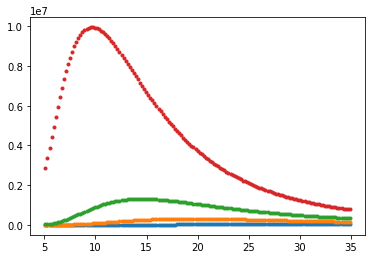

In [17]:
for T in [100,150, 200, 300]:
    fb = B(new_wavelength, T)
    plt.plot(new_wavelength, fb, ".")
plt.show()

### We now make a grid of opacities and temperatures to generate synthetic spectra

In [18]:
nr_of_syn_train = 1500 # This will be our training set

We will randomly pick abundances for the crystalline species between these min and max values. The threshold forsterite abundance is above which we define a spectrum to contain forsterite features which we will use to label the spectra. We also determine the temperature randomly between a min and max value.

In [19]:
cr_a_min, cr_a_max = 0,8
cr_threshold = 3
T_min, T_max = 100, 300

We save the parameters of the spectrum and its label in the grid array. We save the synthetic training spectra in specs.

In [20]:
a_fo = np.array([random.uniform(cr_a_min,cr_a_max) for i in range(nr_of_syn_train)])
a_en = np.array([random.uniform(cr_a_min,cr_a_max) for i in range(nr_of_syn_train)])
a_am = [100-(a_fo[i]+a_en[i]) for i in range(nr_of_syn_train)]
Ts = [random.uniform(T_min,T_max) for i in range(nr_of_syn_train)]
labels = [a_fo[i] > cr_threshold for i in range(nr_of_syn_train)]


In [21]:
grid_train = np.array([a_fo, a_en, a_am, Ts, labels]).T
specs_train = np.array([syn_spec(new_wavelength, [a_fo[i], a_en[i], a_am[i]], 
                           [opac_fo_bin, opac_en_bin, opac_am_bin], Ts[i]) for i in range(len(a_fo))])
specs_train.shape, grid_train.shape

((1500, 149), (1500, 5))

In [101]:
print("Check for nans: ", np.isnan(specs_train).any(), np.isnan(grid_train).any())

Check for nans:  False False


### And we have a look at a generated spectrum

7.4 3.4


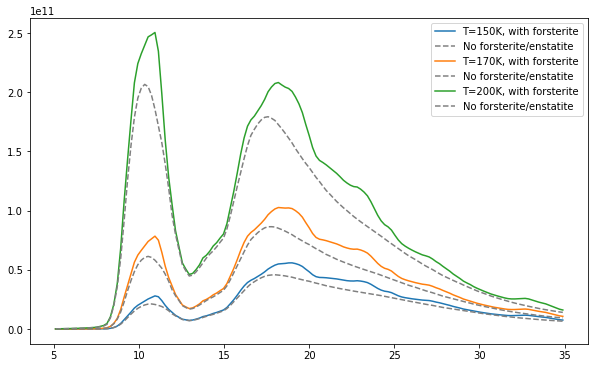

In [22]:
plotfile=''
plt.figure(figsize=(10,6))

i=112
print(round(a_fo[i],1), round(a_en[i],1))
for T in [ 150, 170, 200]:
    s = syn_spec(new_wavelength, [a_fo[i], a_en[i], a_am[i]], [opac_fo_bin, opac_en_bin, opac_am_bin], T)
    s_am = syn_spec(new_wavelength, [a_am[i]], [opac_am_bin], T)
    plt.plot(new_wavelength, s, "-", label="T="+str(T)+"K"+", with forsterite")
    plt.plot(new_wavelength, s_am, "--", color="grey", label="No forsterite/enstatite")
plt.legend()
plt.show()

## Unsupervised: Lets try some principle component analysis

In [23]:
pca_syn = PCA(n_components=4).fit_transform(specs_train) # pca[samples, components]

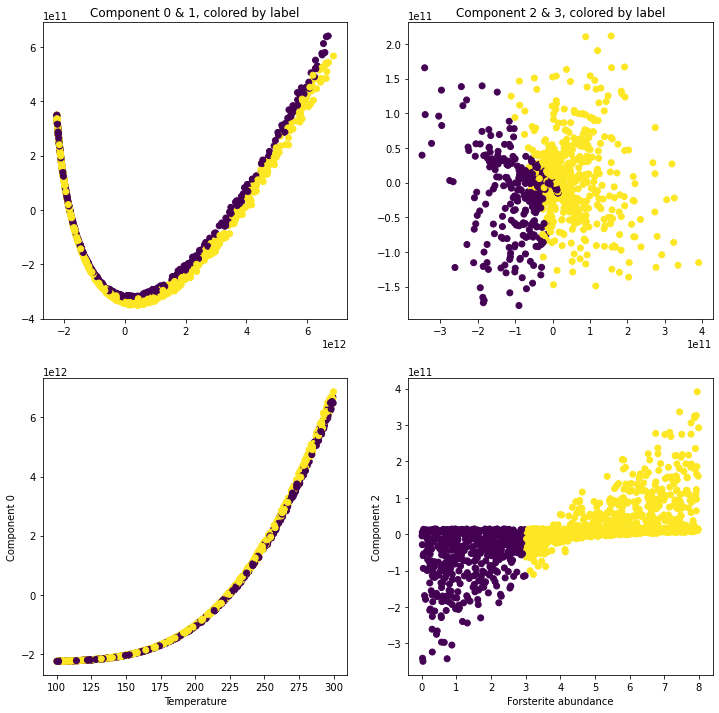

In [24]:
plotfile=''
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.title("Component 0 & 1, colored by label")
plt.scatter(pca_syn[:,0], pca_syn[:,1], c=grid_train[:,4])
plt.subplot(222)
plt.title("Component 2 & 3, colored by label")
plt.scatter(pca_syn[:,2], pca_syn[:,3], c=grid_train[:,4])
plt.subplot(223)
plt.scatter(grid_train[:,3], pca_syn[:,0], c=grid_train[:,4])#, c=grid[:,4])
plt.xlabel("Temperature")
plt.ylabel("Component 0")
plt.subplot(224)
plt.scatter(grid_train[:,0], pca_syn[:,2], c=grid_train[:,4])#, c=grid[:,4])
plt.xlabel("Forsterite abundance")
plt.ylabel("Component 2")
plt.show()

# Things to think about

Think about:
    - Multi task learning (detect multiple things in a spectrum with one network)
    - Transfer learning: learn from synthetic data first and then transfer to real spectra